## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

### [ Reduce Learning Rate  可行的調降方式 ]
1. 每更更新 n 次後，將 Learning rate 做⼀次調降 – schedule decay
2. 當經過幾個 epoch 後，發現 performance 沒有進步 – Reduce on plateau


- Reduce learning rate on plateau：模型沒辦法進步的可能是因為學習率太大導致每次改變量量太大⽽而無法落落入較低的損失平⾯面，透過適度的降低，就有機會得到更更好的結果
- 因為我們可以透過這樣的監控機制，初始的 Learning rate 可以調得比較高，讓訓練過程與 callback 來來做適當的 learning rate 調降。

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\envs\tf\lib\site-packages\tenso

In [2]:
train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
LEARNING_RATE = 1e-3
EPOCHS = 20 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [6]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5] #  factor: factor by which the learning rate will be reduced. new_lr = lr * factor
redice_lr_patient = [5,10]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 10s 207us/step - loss: 1.2246 - accuracy: 0.5770 - val_loss: 1.4591 - val_accuracy: 0.4880
Epoch 14/20
50000/50000 [==============================] - 10s 206us/step - loss: 1.1995 - accuracy: 0.5858 - val_loss: 1.4632 - val_accuracy: 0.4832
Epoch 15/20
50000/50000 [==============================] - 10s 207us/step - loss: 1.1748 - accuracy: 0.5958 - val_loss: 1.4551 - val_accuracy: 0.4903
Epoch 16/20
50000/50000 [==============================] - 10s 206us/step - loss: 1.1528 - accuracy: 0.6044 - val_loss: 1.4573 - val_accuracy: 0.4867
Epoch 17/20
50000/50000 [==============================] - 10s 207us/step - loss: 1.1294 - accuracy: 0.6142 - val_loss: 1.4588 - val_accuracy: 0.4887
Epoch 18/20
50000/50000 [==============================] - 10s 210us/step - loss: 1.1067 - accuracy: 0.6215 - val_loss: 1.4490 - val_accuracy: 0.4913
Epoch 19/20
50000/50000 [==============================] - 10s 205us/step - loss: 1.0852 - accuracy: 0.6287 - va

50000/50000 [==============================] - 10s 203us/step - loss: 1.3977 - accuracy: 0.5131 - val_loss: 1.5534 - val_accuracy: 0.4493
Epoch 8/20
50000/50000 [==============================] - 10s 203us/step - loss: 1.3621 - accuracy: 0.5263 - val_loss: 1.5325 - val_accuracy: 0.4591
Epoch 9/20
50000/50000 [==============================] - 10s 207us/step - loss: 1.3303 - accuracy: 0.5376 - val_loss: 1.5021 - val_accuracy: 0.4682
Epoch 10/20
50000/50000 [==============================] - 10s 206us/step - loss: 1.2984 - accuracy: 0.5491 - val_loss: 1.4886 - val_accuracy: 0.4756
Epoch 11/20
50000/50000 [==============================] - 10s 203us/step - loss: 1.2717 - accuracy: 0.5591 - val_loss: 1.4845 - val_accuracy: 0.4739
Epoch 12/20
50000/50000 [==============================] - 10s 203us/step - loss: 1.2435 - accuracy: 0.5702 - val_loss: 1.4749 - val_accuracy: 0.4748
Epoch 13/20
50000/50000 [==============================] - 10s 202us/step - loss: 1.2161 - accuracy: 0.5803 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 239us/step - loss: 1.9224 - accuracy: 0.3495 - val_loss: 2.1596 - val_accuracy: 0.1943
Epoch 2/20
50000/50000 [==============================] - 10s 209us/step - loss: 1.5843 - accuracy: 0.4483 - val_loss: 1.8975 - val_accuracy: 0.3277
Epoch 3/20
50000/50000 [==============================] - 11s 216us/step - loss: 1.4872 - accuracy: 0.4842 - val_loss: 1.7198 - val_accuracy: 0.4081
Epoch 4/20
50000/50000 [==============================] - 11s 211us/step - loss: 1.4188 - accuracy: 0.5088 - val_loss: 1.6234 - val_accuracy: 0.4424
Epoch 5/20
50000/50000 [==============================] - 11s 223us/step - loss: 1.3682 - accuracy: 0.5271 - val_loss: 1.5663 - val_accuracy: 0.4608
Epoch 6/20
50000/50000 [==============================] - 11s 216us/step - loss: 1.3249 - accuracy: 0.5399 - val_loss: 1.5144 - val_accuracy: 0.4724
Epoch 7/20
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 238us/step - loss: 2.0203 - accuracy: 0.3200 - val_loss: 2.1114 - val_accuracy: 0.2216
Epoch 2/20
50000/50000 [==============================] - 11s 216us/step - loss: 1.6510 - accuracy: 0.4246 - val_loss: 1.9159 - val_accuracy: 0.3380
Epoch 3/20
50000/50000 [==============================] - 11s 215us/step - loss: 1.5568 - accuracy: 0.4562 - val_loss: 1.7748 - val_accuracy: 0.3957
Epoch 4/20
50000/50000 [==============================] - 11s 214us/step - loss: 1.4922 - accuracy: 0.4789 - val_loss: 1.6702 - val_accuracy: 0.4304
Epoch 5/20
50000/50000 [==============================] - 11s 212us/step - loss: 1.4464 - accuracy: 0.4971 - val_loss: 1.6276 - val_accuracy: 0.4370
Epoch 6/20
50000/50000 [==============================] - 11s 212us/step - loss: 1.4062 - accuracy: 0.5122 - val_loss: 1.5678 - val_accuracy: 0.4544
Epoch 7/20
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 227us/step - loss: 1.8472 - accuracy: 0.3694 - val_loss: 2.1166 - val_accuracy: 0.1989
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 1.5606 - accuracy: 0.4543 - val_loss: 1.9050 - val_accuracy: 0.3339
Epoch 3/20
50000/50000 [==============================] - 10s 204us/step - loss: 1.4538 - accuracy: 0.4955 - val_loss: 1.7397 - val_accuracy: 0.3912
Epoch 4/20
50000/50000 [==============================] - 10s 205us/step - loss: 1.3773 - accuracy: 0.5210 - val_loss: 1.7976 - val_accuracy: 0.3398
Epoch 5/20
50000/50000 [==============================] - 10s 204us/step - loss: 1.3174 - accuracy: 0.5421 - val_loss: 1.6953 - val_accuracy: 0.3985
Epoch 6/20
50000/50000 [==============================] - 11s 211us/step - loss: 1.2675 - accuracy: 0.5593 - val_loss: 1.7403 - val_accuracy: 0.3880
Epoch 7/20
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 230us/step - loss: 1.9200 - accuracy: 0.3457 - val_loss: 2.0628 - val_accuracy: 0.2670
Epoch 2/20
50000/50000 [==============================] - 10s 208us/step - loss: 1.6187 - accuracy: 0.4361 - val_loss: 1.8950 - val_accuracy: 0.3371
Epoch 3/20
50000/50000 [==============================] - 10s 208us/step - loss: 1.5127 - accuracy: 0.4731 - val_loss: 1.7391 - val_accuracy: 0.4114
Epoch 4/20
50000/50000 [==============================] - 11s 211us/step - loss: 1.4369 - accuracy: 0.5002 - val_loss: 1.6727 - val_accuracy: 0.4245
Epoch 5/20
50000/50000 [==============================] - 10s 209us/step - loss: 1.3725 - accuracy: 0.5226 - val_loss: 1.6379 - val_accuracy: 0.4241
Epoch 6/20
50000/50000 [==============================] - 10s 208us/step - loss: 1.3211 - accuracy: 0.5420 - val_loss: 1.5760 - val_accuracy: 0.4505
Epoch 7/20
50000/50000 [==============================] 

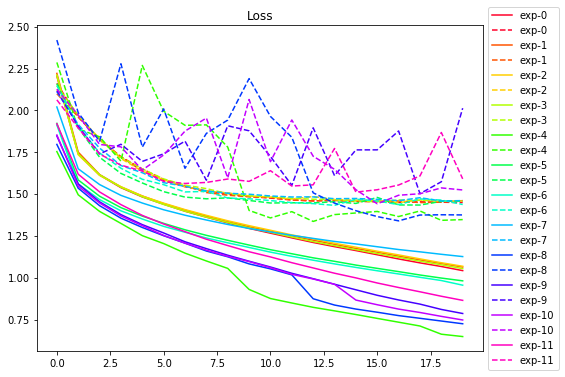

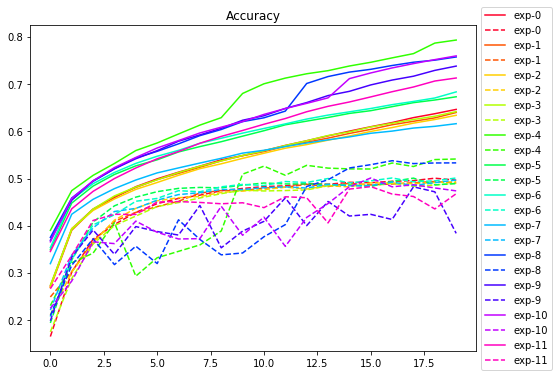

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## [ 延伸閱讀 ]
### Github 原碼：LearningRateScheduler 與 ReduceLR
- LearningRateScheduler  [連結(1)](https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L910)
- ReduceLR  [ 連結(2)](https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L946)